In [1]:
# Import the SymPy Module
import sympy

# Import the necessary sub-modules and methods for dynamics
from sympy.physics.mechanics import dynamicsymbols
from sympy.physics.mechanics import inertia, LagrangesMethod, Lagrangian
from sympy.physics.mechanics import Particle, Point, ReferenceFrame, RigidBody

# initiate better printing of SymPy results
sympy.init_printing()

In [2]:

# Define the genearlized coordinate
x, theta1, f = dynamicsymbols('x theta_1 f')

# Also define the first derivative
x_dot, theta1_dot = dynamicsymbols('x theta_1', 1)

# Define the symbols for the other paramters
m, mt, g, k, L, Izz, t = sympy.symbols('m mt g k L I_zz t')

In [3]:
N = ReferenceFrame('N')

# Define a body-fixed frame along the spring, with y aligned from m to the pin
A = N.orientnew('A', 'Axis', [theta1, N.z])
# B = N.orientnew('B', 'Axis', [theta2, N.z])

# Define an origin and set its velocity to 0
O = Point('0')
O.set_vel(N, 0 * N.x)

# Create the trolley - treat as a particle
T = O.locatenew('T', x * N.x)
T.set_vel(N, x_dot * N.x)

# Define the point at the end of the spring and set its velocity
P = T.locatenew('P', -L * A.y)
P.set_vel(N, x_dot * N.x + L * theta1_dot * A.x)

In [4]:
# Define the COM of the bar location and velocity
# G = P.locatenew('G', -l/2 * B.y)
# G.v2pt_theory(P, N, A)

# Create the bar rigid bogy
# I_bar = inertia(B, 0, 0, Izz)
# bar = RigidBody('bar', G, B, m, (I_bar, G))

# Treat the trolley as a particle
mtr = Particle('mtr', T, mt)
end = Particle('end', P, m)

# Now, set the potential energy of the bar
h = P.pos_from(T) & N.y # Define the height of the COM by the vertical distance from the datum
end.potential_energy = (m * g * h)

# # Set up the force list - each item follows the form:
# #    (the location where the force is applied, its magnitude and direction)
# # Here, there are no non-conservataive external forces
forces = [(T, f * N.x)]

# # Form the Lagrangian
L =  Lagrangian(N, mtr, end)

# # Print the Lagrangian as a check
L

In [5]:
LM = LagrangesMethod(L, [x, theta1], forcelist = forces, frame = N)
EqMotion = LM.form_lagranges_equations()
lrhs = LM.rhs()

In [6]:
# import NumPy with namespace np
import numpy as np

# import the scipy ODE solver
from scipy.integrate import ode

# import the plotting functions from matplotlib
import matplotlib.pyplot as plt

# set up the notebook to display the plots inline
%matplotlib inline

In [7]:
# define the forcing function
def force(t):
    # set the maximum force output
    fmax = 0.0
    
    # return a bang-bang command
    return fmax * (t > 0.5)

In [8]:
# Define the states and state vector
w1, w2, w3, w4 = sympy.symbols('w1 w2 w3 w4', cls=sympy.Function)
w = [w1(t), w2(t), w3(t), w4(t)]

# Set up the state definitions and parameter substitution
sub_params = {x : w1(t),
              theta1: w2(t),
              x_dot : w3(t),
              theta1_dot : w4(t), 
              m : 10.0,
              mt : 100.0,
              g : 9.81,
              L : 2.0,
              f: force(t)}

# set this parameter to enable array output from sympy.lambdify
mat2array = [{'ImmutableMatrix': np.array}, 'numpy']

# Create a function from the equations of motion
# Here, we substitude the states and parameters as appropriate prior to the lamdification
eq_of_motion = sympy.lambdify((t, w), 
                              lrhs.subs(sub_params), 
                              modules = mat2array)

In [20]:
# Set up the initial conditions for the solver
x_init = 0.0                   # Initial Trolley position (m)
x_dot_init = 0.0                # Initial trolley velocity (m/s)

theta1_init = 0.7               # Initial angle (rad)
theta1_dot_init = 0.0           # Initial angular velocity (rad/s)


# Pack the initial conditions into an array
x0 = [x_init, theta1_init, x_dot_init, theta1_dot_init]

# Create the time samples for the output of the ODE solver
sim_time = np.linspace(0.0, 30.0, 900) # 0-10s with 1001 points in between

In [21]:
# Set up the initial point for the ode solver
r = ode(eq_of_motion).set_initial_value(x0, sim_time[0])
 
# define the sample time
dt = sim_time[1] - sim_time[0]   

# pre-populate the response array with zeros
response = np.zeros((len(sim_time), len(x0)))

# Set the initial index to 0
index = 0

# Now, numerically integrate the ODE while:
#   1. the last step was successful
#   2. the current time is less than the desired simluation end time
while r.successful() and r.t <= (sim_time[-1] + 1e-9):
    response[index, :] = r.y
    r.integrate(r.t + dt)
    index += 1

TypeError: can't convert expression to float

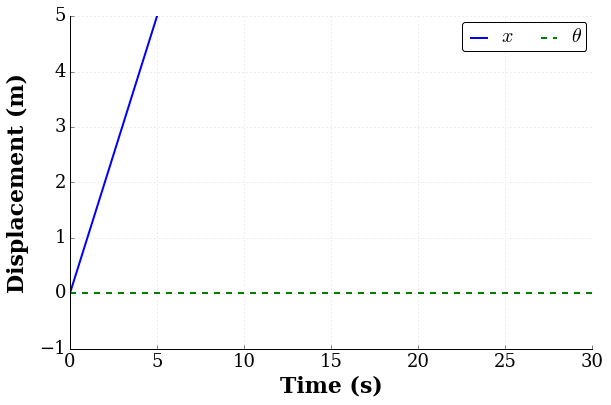

In [19]:
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

# Remove top and right axes border
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Only show axes ticks on the bottom and left axes
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Displacement (m)', family='serif', fontsize=22, weight='bold', labelpad=10)

# Plot the data
plt.plot(sim_time, response[:, 0], linewidth=2, linestyle='-', label = r'$x$')
plt.plot(sim_time, response[:, 1], linewidth=2, linestyle='--', label = r'$\theta$')

# uncomment below and set limits if needed
# plt.xlim(0, 5)
plt.ylim(-1, 5)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', ncol = 2, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext, family='serif', fontsize=20)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# Uncomment to save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('SpringBar_Pendulum_InitCondResponse_CartAndRadial.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook